# Deep Water Bathymetric Particle Filter Experiment

This notebook runs the experiment testing the capabilities of the particle filter to conduct navigation using deep water bathymetry and for long duration.

## Data set preparation

First need to process the .m77t files in `source_data` into our database format.

In [5]:
from src import process_dataset as pdset
import os
import pandas as pd

### Preprocess tracklines into sql/df format

In [6]:
# Check to see if the database exists
if not os.path.exists('.db/tracklines.db'):
    tables = []
else:
    tables = pdset.get_tables('.db/tracklines.db')

source_data_location = "./source_data/"
# walk through the .m77t files in the source_data directory
for root, dirs, files in os.walk(source_data_location):
    for file in files:
        if file.endswith(".m77t"):
            # check to see if the file has already been processed
            filename = os.path.splitext(file)[0]
            if filename not in tables:
                print("Processing file: " + file)
                data = pd.read_csv(os.path.join(root, file), delimiter="\t", header=0)
                data = pdset.m77t_to_df(data)
                # data.to_sql(
                #    filename, sqlite3.connect(".db/tracklines.db"), if_exists="replace"
                # )
                pdset.save_dataset(
                    [data],
                    [filename],
                    output_location=".db",
                    output_format="db",
                    dataset_name="tracklines",
                )
            else:
                print("Skipping file: " + file + " (already processed)")

Skipping file: ew0114.m77t (already processed)
Skipping file: wi933014.m77t (already processed)
Skipping file: ew0102.m77t (already processed)
Skipping file: 78123006.m77t (already processed)
Skipping file: ew0112.m77t (already processed)
Skipping file: ew0007.m77t (already processed)
Skipping file: index17.m77t (already processed)
Skipping file: ew9704.m77t (already processed)


### Parse the raw data into tracklines of continuous data collections

In [7]:
max_time = 10 # minutes
max_delta_t = 2 # minutes between points
min_duration = 60 # minutes, minimum duration for a useful trackline

data, names = pdset.parse_tracklines_from_db(
    ".db/tracklines.db",
    #max_time,
    #max_delta_t,
    #min_duration,
    data_types=[
        "bathy",
        "mag",
        "grav",
        ["bathy", "mag"],
        ["bathy", "grav"],
        ["grav", "mag"],
        ["bathy", "grav", "mag"],
    ],
)
# Save the parsed data to the database
pdset.save_dataset(
    data, names, output_location=".db", output_format="db", dataset_name="parsed"
)
#summary = pdset.get_parsed_data_summary(data, names)

Processing: ew0114
Processing: wi933014
Processing: ew0102
Processing: 78123006
Processing: ew0112
Processing: ew0007
Processing: index17
Processing: ew9704


## Simulation parameters verification

First we need to tune the particle filter propagation noise to be similar to that of a marine-grade inertial navigation system. A low-end marine-grade INS should have a drift of 1 nm per 24 hours.

In [8]:
from src.particle_filter import rmse, propagate
import numpy as np

time = 24*60 # minutes
noise = np.array([0, 2.6, 0])
bound = 1852 # meters

errors = []
for v in range(1, 26):
    P = np.asarray([[0,0,0,0,v,0]])
    T = P.copy()
    t = 0
    for i in range(10000):
        # Eastward
        u = [0,v,0]
        while t < time:    
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0,0,0]), noise_calibration_mode=False)
            t+=1
        errors.append(rmse(P, T[0, :2]))
        # Northward
        u = [v,0,0]
        while t < time:    
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0,0,0]), noise_calibration_mode=False)
            t+=1
        errors.append(rmse(P, T[0, :2]))
        # Northeastward 
        u = np.array([1,1,0]) / np.linalg.norm([1,1,0])
        u *= v
        while t < time:    
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0,0,0]), noise_calibration_mode=False)
            t+=1
        errors.append(rmse(P, T[0, :2]))

print(f"RMSE: {np.mean(errors)}")

RMSE: 1852.9770557242362


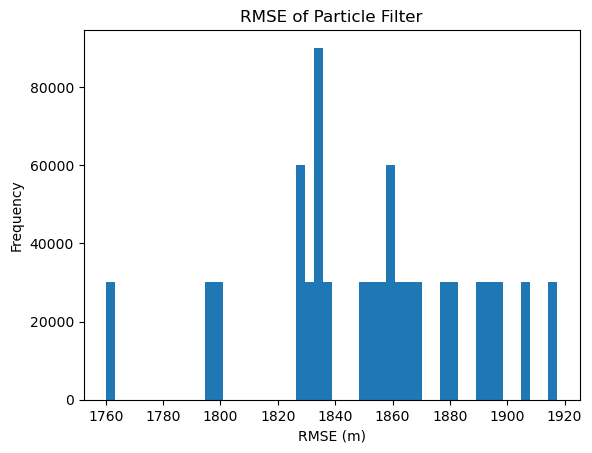

In [9]:
from matplotlib import pyplot as plt

plt.hist(errors, bins=50)
plt.xlabel("RMSE (m)")
plt.ylabel("Frequency")
plt.title("RMSE of Particle Filter")
plt.savefig(".db/plots/propagation_tuning.png")
plt.show()

In [10]:
config = {"velocity_noise": [noise[1], noise[1], 0]}

Next we need to develop the measurement value standard deviation. We'll first do some general examination of the data. Namely, investigating the sensor measurements to see if we can build a reasonable sensor model.

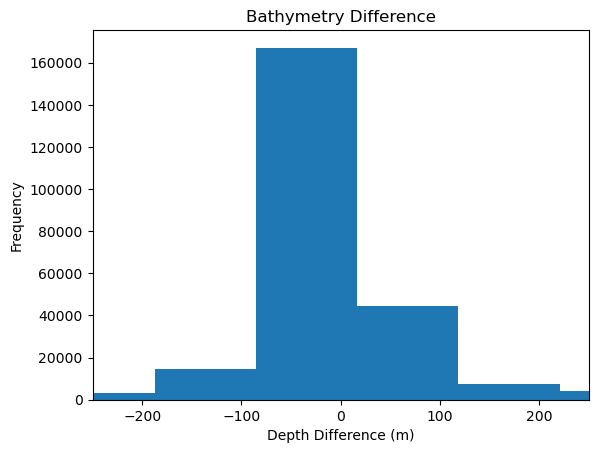

In [11]:
from src.gmt_tool import inflate_bounds, get_map_section, get_map_point
import numpy as np

tables = pdset.get_tables(".db/parsed.db")
bathy_tables = [table for table in tables if "_D_" in table]

d_bathy = np.array([])

for table in bathy_tables:
    data = pdset.table_to_df(".db/parsed.db", table)
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    bathy_map = get_map_section(min_lon, max_lon, min_lat, max_lat, 'relief', '15s', "temp")
    d_bathy = np.hstack([d_bathy, data['DEPTH'] - (-get_map_point(bathy_map, data.LON, data.LAT))])

config['bathy_mean_d'] = np.mean(d_bathy, where=~np.isnan(d_bathy))
config['bathy_std'] = np.std(d_bathy, where=~np.isnan(d_bathy))

plt.hist(d_bathy, bins=100)
plt.xlim([-250,250])
plt.xlabel("Depth Difference (m)")
plt.ylabel("Frequency")
plt.title("Bathymetry Difference")
plt.savefig(".db/plots/bathy_diff.png")
plt.show()

In [12]:
import json

with open("config.json", "w") as f:
    json.dump(config, f)

### Populate with velocities

In [13]:
from src.particle_filter import process_particle_filter, populate_velocities, plot_error, plot_estimate, summarize_results
import json
import src.process_dataset as pdset
from tqdm import tqdm
import pandas as pd
import os

In [14]:
tables = pdset.get_tables(".db/parsed.db")
bathy_tables = [table for table in tables if "_D_" in table]
config = json.load(open("config.json", "r"))
config["n"] = 10000
config["cov"] = [1/60, 1/60, 0, config["velocity_noise"][0], config["velocity_noise"][1], 0]

with open("config.json", "w") as f:
    json.dump(config, f)

In [15]:
config

{'velocity_noise': [2.6, 2.6, 0],
 'bathy_mean_d': 21.285045267468078,
 'bathy_std': 215.01077619593897,
 'n': 10000,
 'cov': [0.016666666666666666, 0.016666666666666666, 0, 2.6, 2.6, 0]}

In [16]:
if not os.path.exists('.db/plots/estimate/'):
    os.makedirs('.db/plots/estimate/')

if not os.path.exists('.db/plots/errors/'):
    os.makedirs('.db/plots/errors/')

summary = None
annotations = {"recovery": 1852, "res":1852/4}
for table in tqdm(bathy_tables):
    df = pdset.table_to_df(".db/parsed.db", table)
    df = populate_velocities(df)
    results, geo_map = process_particle_filter(df, config)
    run = summarize_results(results, 1852)
    run["Name"] = table
    pdset.save_dataset(
        [results], [table], output_location=".db", output_format="db", dataset_name="results"
    )
    fig, ax = plot_estimate(geo_map, results)
    fig.savefig(f".db/plots/estimate/{table}_estimate.png")
    plt.close(fig)
    fig, ax = plot_error(results, annotations=annotations)
    fig.savefig(f".db/plots/errors/{table}_error.png")
    plt.close(fig)

  0%|          | 1/247 [00:14<1:01:16, 14.94s/it]/home/james/research_workspace/geophysical_nav/src/particle_filter.py:106: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
/home/james/miniconda3/envs/nav/lib/python3.11/site-packages/filterpy/monte_carlo/resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)
  1%|          | 2/247 [36:42<87:59:45, 1293.00s/it]/home/james/research_workspace/geophysical_nav/src/particle_filter.py:106: RuntimeWarning: invalid value encountered in divide
  new_weights = w / w_sum
/home/james/miniconda3/envs/nav/lib/python3.11/site-packages/filterpy/monte_carlo/resampling.py:61: RuntimeWarning: invalid value encountered in cast
  num_copies = (np.floor(N*np.asarray(weights))).astype(int)
  1%|          | 3/247 [56:13<83:52:22, 1237.47s/it]/home/james/research_workspace/geophysical_nav/src/particle_filter.py:106: RuntimeWarning: invalid value encountered in

In [ ]:
summary = None
results_tables = pdset.get_tables(".db/results.db")
for table in results_tables:
    df = pdset.table_to_df(".db/results.db", table)
    run = summarize_results(df, 1852)
    run["Name"] = table
    if summary is None:
        summary = run#.copy()
    else:
        summary = pd.concat([summary, run], ignore_index=True)
    summary.to_csv(".db/summary_recovery.csv")

In [ ]:
summary = None
results_tables = pdset.get_tables(".db/results.db")
for table in results_tables:
    df = pdset.table_to_df(".db/results.db", table)
    run = summarize_results(df, 452)
    run["Name"] = table
    if summary is None:
        summary = run#.copy()
    else:
        summary = pd.concat([summary, run], ignore_index=True)
    summary.to_csv(".db/summary_resolution.csv")